# **Setup**

### Install packages and setup

In [2]:
! pip install split-folders visualkeras GPUtil
! pip install ninja torch===1.7.1+cu110 torchvision===0.8.2+cu110 torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

import numpy as np
from PIL import Image
from numba import cuda
from tensorflow import keras
import matplotlib.pyplot as plt
from IPython.display import FileLink
from GPUtil import showUtilization as gpu_usage
import os, glob, json, splitfolders, visualkeras, pathlib, h5py, torch, pickle

SHOES = '/kaggle/input/nikeshoes/nikeshoes'
CLASS, GENER, BACKUP, OUTPUT = "classification", "generation", 'backup', 'output'
GAN = 'stylegan2-ada-pytorch' 
! cd '/kaggle/working'

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.9/989.9 kB 7.7 MB/s eta 0:00:00a 0:00:01
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=732de6e84044478823241e1a45925029a71ab22bd2afd95c0e471d027d8f68c0
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 796.7 kB/s eta 0:00:0000:010:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 65.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 28.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0
    Uninstalling torch-1.11.0:
      Successfully uninstalled torch-1.11.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0
    Unins

### Import and explore data

In [3]:
pairs = [os.path.basename(path.rstrip('/')) for path in glob.glob(f"{SHOES}/*/")]
num_images  = {pair: len(glob.glob(f"{SHOES}/{pair}/*")) for pair in pairs}
mean_sizes = np.array([Image.open(path).size for path in glob.glob(f"{SHOES}/*/*")]).mean(axis=0)

print(f"\nNumber of images per pair:\n{num_images}\n")
print(f"Images' mean widht and height: {mean_sizes}")


Number of images per pair:
{'Nike Air Jordan 1 High': 395, 'Nike Dunk Low': 595, 'Nike Air Max 1': 387, 'Nike Air Force 1': 830}

Images' mean widht and height: [817.39374717 412.17942909]


# **Shoe Classification**


### Split data

In [4]:
WIDTH, HEIGHT = 256, 128 
PROPORTIONS = [0.8, 0.1, 0.1]

num_pairs, min_num_images = len(pairs), min(num_images.values())

!rm -rf $classification
proportions = [int(min_num_images*x) for x in PROPORTIONS]
splitfolders.fixed(SHOES, output=CLASS, seed=42, fixed=proportions, move=False) 

def get_data(type="test"):
  paths = glob.glob(f"{CLASS}/{type}/*/*")
  np.random.shuffle(paths)
  
  images = [np.array(Image.open(path).resize((WIDTH, HEIGHT))) for path in paths]
  images = np.array(images)/255
    
  labels = [pairs.index(path.split('/')[-2]) for path in paths]
  labels = keras.utils.to_categorical(labels, num_pairs)

  return images, labels

(x_train, y_train), (x_val, y_val), (x_test, y_test) = get_data('train'), get_data('val'), get_data('test')
print(f"Train shape: {x_train.shape}, Validation shape: {x_val.shape}, Test shape: {x_test.shape}")

Copying files: 1540 files [00:06, 223.02 files/s]


Train shape: (1236, 128, 256, 3), Validation shape: (152, 128, 256, 3), Test shape: (152, 128, 256, 3)


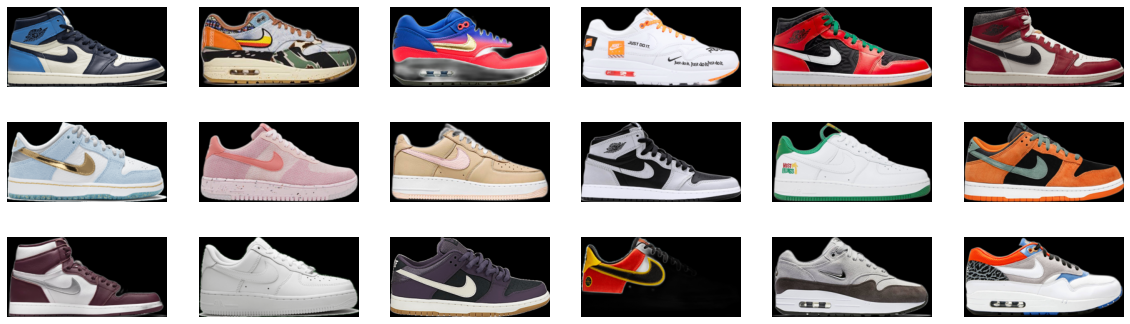

In [5]:
# Plot a few train images
m, n = 3, 6
plt.figure(figsize=(20,6))
for count, image in enumerate(x_train[:m*n]):
  plt.subplot(m,n,count+1)
  plt.axis("off"); plt.grid(False)
  plt.imshow(image, cmap=plt.cm.binary)
plt.show()

### Build the model

2022-12-11 11:53:36.557453: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 11:53:36.558520: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 11:53:36.827876: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 11:53:36.828734: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 11:53:36.829568: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 254, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 127, 128)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 125, 128)      147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 62, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 60, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 30, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 28, 128)       1

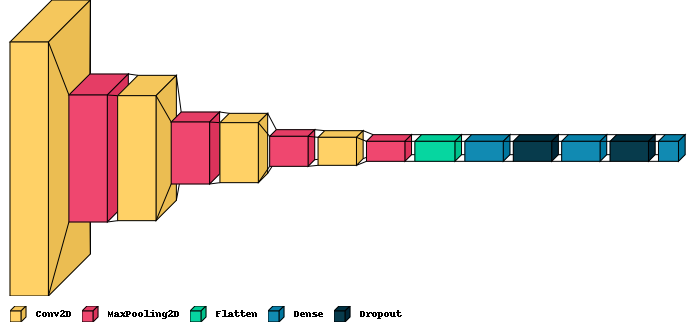

In [6]:
KNL = (3,3)
POOL = (2,2)
model = keras.Sequential(
    [
        keras.Input(shape=(HEIGHT, WIDTH, 3)),
        keras.layers.Conv2D(128, kernel_size=KNL, activation="relu"),
        keras.layers.MaxPooling2D(pool_size=POOL),
        keras.layers.Conv2D(128, kernel_size=KNL, activation="relu"),
        keras.layers.MaxPooling2D(pool_size=POOL),
        keras.layers.Conv2D(128, kernel_size=KNL, activation="relu"),
        keras.layers.MaxPooling2D(pool_size=POOL),
        keras.layers.Conv2D(128, kernel_size=KNL, activation="relu"),
        keras.layers.MaxPooling2D(pool_size=POOL),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(num_pairs, activation="softmax"),
    ]
)

model.summary()
visualkeras.layered_view(model, legend=True, scale_xy=1, scale_z=0.3, spacing=10, max_z=40)

### Train the model and save it

In [7]:
BATCH_SIZE = 200
EPOCHS = 20

# Set a callback function to save the best model so far
save_filepath = f'{BACKUP}/classification.h5'
callbacks = [keras.callbacks.ModelCheckpoint(filepath=save_filepath, monitor='val_loss', save_best_only=True)]

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_val, y_val), callbacks=callbacks)

# Save the necessary model parameters for later use.
file = h5py.File(save_filepath, 'r+')
file.attrs['metadata'] = json.dumps({'pairs': pairs, 'width': WIDTH, 'height': HEIGHT})
file.close()

2022-12-11 11:53:42.823101: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 486014976 exceeds 10% of free system memory.
2022-12-11 11:53:43.462236: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 486014976 exceeds 10% of free system memory.
2022-12-11 11:53:43.931529: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-12-11 11:53:44.861284: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 78643200 exceeds 10% of free system memory.
2022-12-11 11:53:44.861424: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 78643200 exceeds 10% of free system memory.
2022-12-11 11:53:44.948237: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 78643200 exceeds 10% of free system memory.
2022-12-11 11:53:46.718931: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


7/7 [==============================] - 26s 1s/step - loss: 1.2493 - accuracy: 0.3883 - val_loss: 0.7920 - val_accuracy: 0.6513
Epoch 2/20
7/7 [==============================] - 3s 442ms/step - loss: 0.8878 - accuracy: 0.6028 - val_loss: 0.5896 - val_accuracy: 0.7895
Epoch 3/20
7/7 [==============================] - 3s 443ms/step - loss: 0.6763 - accuracy: 0.7427 - val_loss: 0.4338 - val_accuracy: 0.8158
Epoch 4/20
7/7 [==============================] - 3s 441ms/step - loss: 0.4500 - accuracy: 0.8341 - val_loss: 0.3685 - val_accuracy: 0.9013
Epoch 5/20
7/7 [==============================] - 3s 445ms/step - loss: 0.3729 - accuracy: 0.8681 - val_loss: 0.3195 - val_accuracy: 0.9079
Epoch 6/20
7/7 [==============================] - 3s 445ms/step - loss: 0.3205 - accuracy: 0.8956 - val_loss: 0.2910 - val_accuracy: 0.9013
Epoch 7/20
7/7 [==============================] - 3s 444ms/step - loss: 0.2621 - accuracy: 0.9110 - val_loss: 0.2436 - val_accuracy: 0.9474
Epoch 8/20
7/7 [=================

### Evaluate the model

5/5 [==============================] - 2s 234ms/step - loss: 0.1046 - accuracy: 0.9737

Test loss: 0.10461904853582382 
Test accuracy: 0.9736841917037964 



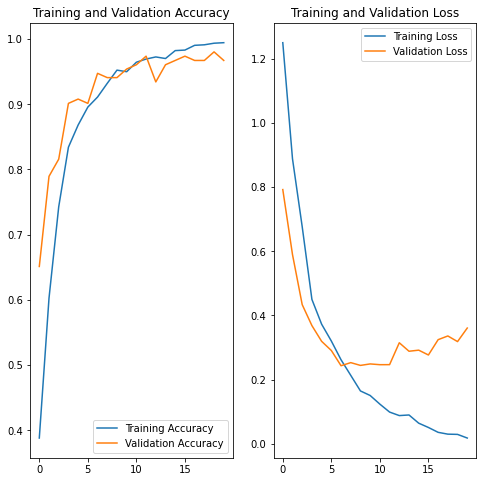

In [8]:
score = model.evaluate(x_test, y_test)
print(f"\nTest loss: {score[0]} \nTest accuracy: {score[1]} \n")

hist = history.history 
acc, val_acc, loss, val_loss = hist['accuracy'], hist['val_accuracy'], hist['loss'], hist['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy'); plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right'); plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss'); plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right'); plt.title('Training and Validation Loss')
plt.show()

# **Design Generation**


### Clear the GPU cache to avoid memory errors


In [9]:
print("Initial GPU Uscage"); gpu_usage()
for _ in range(3):
    torch.cuda.empty_cache()
    cuda.select_device(0); cuda.close(); cuda.select_device(0)
print("GPU Usage after emptying the cache"); gpu_usage()

Initial GPU Uscage
| ID | GPU | MEM |
------------------
|  0 |  0% | 96% |
|  1 |  0% |  2% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  4% |  1% |
|  1 |  0% |  0% |


### Train a StyleGan2 model with our images

In [3]:
SIZE, GPUS, SNAP, KIMG = 128, 2, 50, 1000

! mkdir -p $GENER
! git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
! python $GAN/dataset_tool.py --source $SHOES --dest $GENER/data --width $SIZE --height $SIZE
! python $GAN/train.py --data $GENER/data --outdir $GENER/results --snap $SNAP --kimg $KIMG --gpus $GPUS

# Save the model and training images in the backup folder
for ext in ('pkl', 'png'):
    for file in glob.glob(f"{GENER}/results/*/*.{ext}"):
        ! cp -r $file $BACKUP
        
latest_snapshot = max(glob.glob(f"{BACKUP}/*.pkl"))
with open(latest_snapshot, 'wb') as f:
    pickle.dump({'resolution': SIZE}, f)

fatal: destination path 'stylegan2-ada-pytorch' already exists and is not an empty directory.
Error: --dest folder must be empty

Training options:
{
  "num_gpus": 2,
  "image_snapshot_ticks": 50,
  "network_snapshot_ticks": 50,
  "metrics": [
    "fid50k_full"
  ],
  "random_seed": 0,
  "training_set_kwargs": {
    "class_name": "training.dataset.ImageFolderDataset",
    "path": "generation/data",
    "use_labels": false,
    "max_size": 2207,
    "xflip": false,
    "resolution": 128
  },
  "data_loader_kwargs": {
    "pin_memory": true,
    "num_workers": 3,
    "prefetch_factor": 2
  },
  "G_kwargs": {
    "class_name": "training.networks.Generator",
    "z_dim": 512,
    "w_dim": 512,
    "mapping_kwargs": {
      "num_layers": 2
    },
    "synthesis_kwargs": {
      "channel_base": 16384,
      "channel_max": 512,
      "num_fp16_res": 4,
      "conv_clamp": 256
    }
  },
  "D_kwargs": {
    "class_name": "training.networks.Discriminator",
    "block_kwargs": {},
    "mapping_k

# **Load and use saved models**

### Classify pairs


2022-12-11 00:08:02.283941: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 00:08:02.286428: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 00:08:02.485722: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 00:08:02.487100: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 00:08:02.488185: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

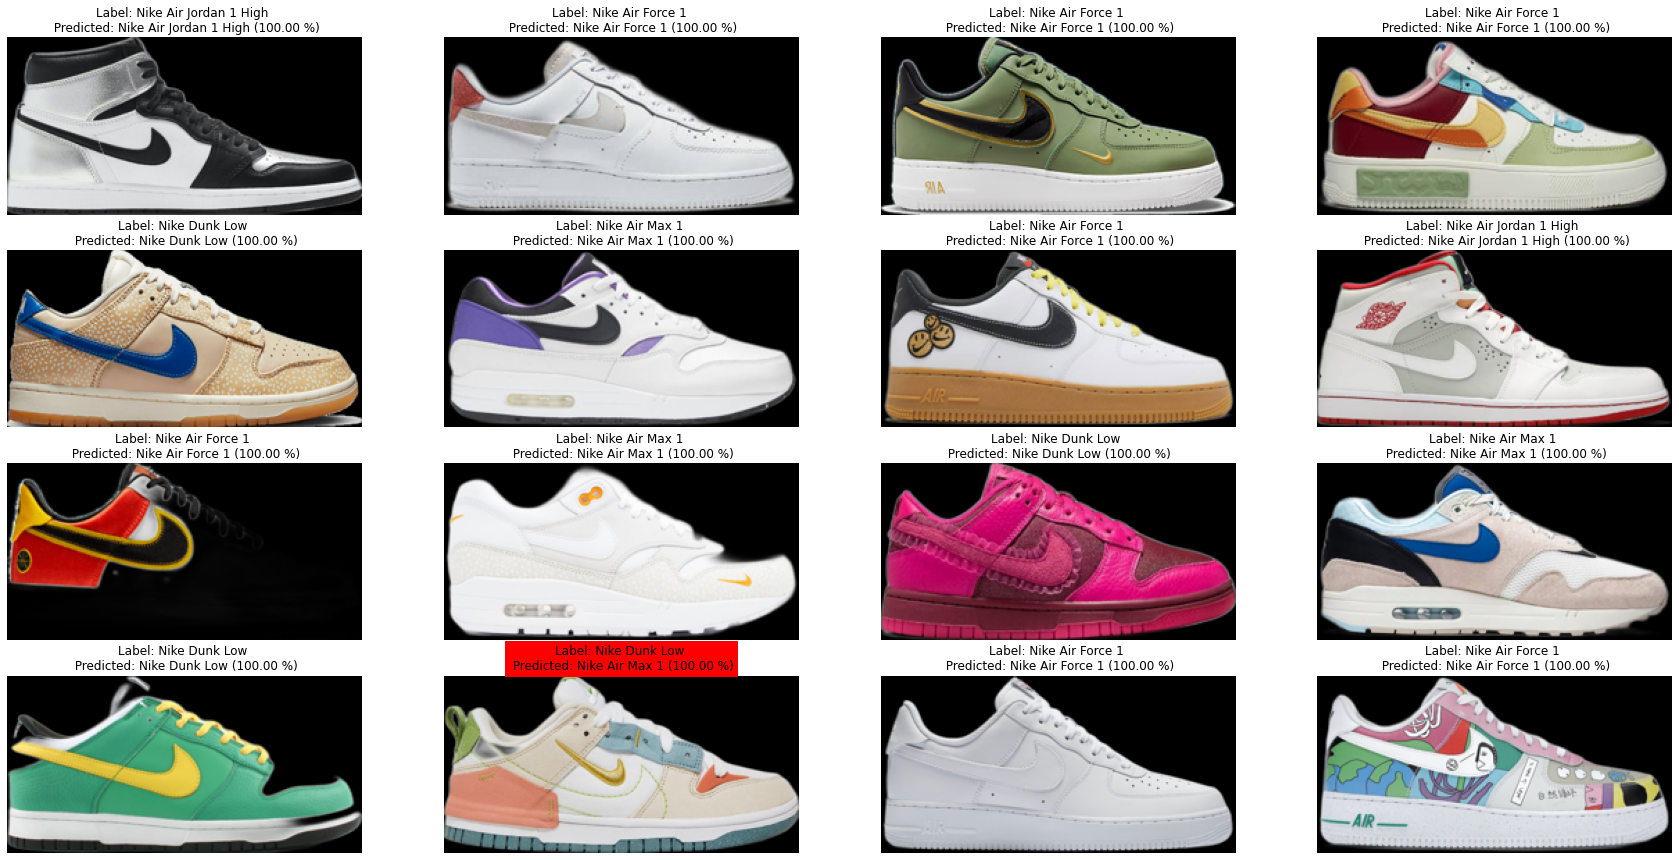

In [4]:
# Retrieve the classification model and the pairs indexes
params = json.load(open(f'{BACKUP}/parameters.json', 'r'))
pairs_, width_, height_ = params['pairs'], params['width'], params['height']

classification_model = keras.models.load_model(f'{BACKUP}/model.h5')
predictor = classification_model.predict

# Plot shoes and predict their type
m,n = 4,4
figure, axes = plt.subplots(ncols=m, nrows=n, figsize=(30,15))

random_paths = np.random.choice(glob.glob(f"{SHOES}/*/*.png"), m*n)
for ind, path in enumerate(random_paths):
    image = np.array(Image.open(path).resize((width_, height_)))
    probas = predictor(np.array([image]), verbose=False)[0]
    predicted = pairs_[np.argmax(probas)]

    label = os.path.basename(os.path.dirname(path)) 
    max_proba = '{:.2f}'.format(100*max(probas))
    title = f"Label: {label} \n Predicted: {predicted} ({max_proba} %)"
    color_dict = {'backgroundcolor':'red'} if label!=predicted else {} 

    axis = axes[ind//m, ind%n]
    axis.set_title(title, **color_dict)
    axis.imshow(image); axis.axis("off")

plt.grid(False); 
plt.show()

### Generate designs




Loading networks from "backup/network-snapshot-001000.pkl"...
Generating image for seed 85 (0/4) ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Generating image for seed 265 (1/4) ...
Generating image for seed 297 (2/4) ...
Generating image for seed 849 (3/4) ...


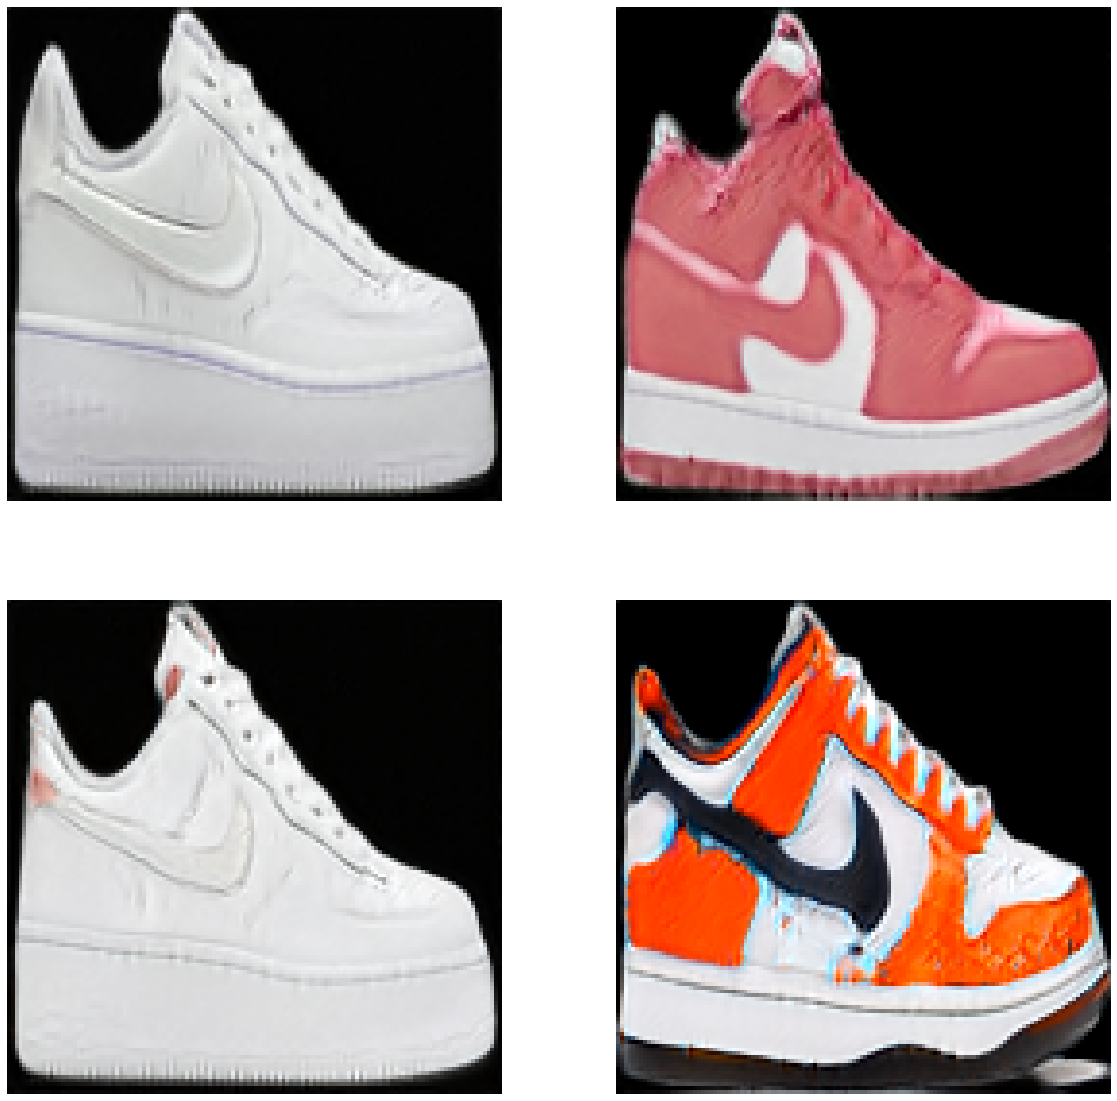

In [14]:
# Get the latest trained StyleGan model and generate a design
GAN = 'stylegan2-ada-pytorch' 
BACKUP = 'backup'

snapshot = max(glob.glob(f"{BACKUP}/*.pkl"))
! python $GAN/generate.py --network=$snapshot --outdir=$OUTPUT --seeds=85,265,297,849 --trunc=1

figure, axes = plt.subplots(ncols=2, nrows=2, figsize=(20,20))
for ind, path in enumerate(glob.glob(f'{OUTPUT}/*')):
    axis = axes[ind//2, ind%2]
    axis.imshow(np.array(Image.open(path))); axis.axis("off")
plt.grid(False); plt.show()

### Create a link to download the backup files

In [15]:
! zip -r backup.zip $BACKUP
FileLink('backup.zip')

  adding: backup/ (stored 0%)
  adding: backup/network-snapshot-000201.pkl (deflated 7%)
  adding: backup/fakes000000.png (deflated 0%)
  adding: backup/reals.png (deflated 0%)
  adding: backup/fakes000604.png (deflated 0%)
  adding: backup/parameters.json (deflated 24%)
  adding: backup/network-snapshot-000000.pkl (deflated 8%)
  adding: backup/network-snapshot-000806.pkl (deflated 7%)
  adding: backup/fakes000806.png (deflated 0%)
  adding: backup/network-snapshot-001000.pkl (deflated 7%)
  adding: backup/fakes001000.png (deflated 0%)
  adding: backup/fakes000201.png (deflated 0%)
  adding: backup/fakes000403.png (deflated 0%)
  adding: backup/fakes_init.png (deflated 0%)
  adding: backup/network-snapshot-000604.pkl (deflated 7%)
  adding: backup/network-snapshot-000403.pkl (deflated 7%)
  adding: backup/model.h5 (deflated 9%)


/kaggle/working/backup.zip